# Solving a boundary valued problem using different constitutive law relations in Fenics.

Import libraries useful for running the code

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import fenics as fe
import matplotlib.pyplot as plt
import ufl_legacy as ufl
from dolfin import *
import mshr

Set matplotlib parameters to create prettier plots

In [ ]:
plt.rc('font', family='sans-serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "sans-serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 16,
                      'lines.linewidth': 1,
                      'axes.labelsize': 16,
                      'axes.titlesize': 16,
                      'xtick.labelsize': 16,
                      'ytick.labelsize': 16,
                      'legend.fontsize': 16,
                      'axes.linewidth': 0.1})

plt.rcParams.update({'figure.dpi': '100'})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma']

Create the domain geometry and discretize it using a mesh

In [ ]:
fe.set_log_level(13)

x_low  = 0.0
x_high = 1.0
y_low  = 0.0
y_high = 1.0

dd = mshr.Circle(Point(x_low,y_low), 0.1)
domain = mshr.Rectangle(Point(x_low,y_low), Point(x_high, y_high))- dd
mesh = mshr.generate_mesh(domain, 32)

Set the test function space, the domain and the measure.

In [ ]:
VS = VectorElement("Lagrange", mesh.ufl_cell(), 2)
W = FunctionSpace(mesh, VS)

domain = MeshFunction('size_t',mesh,mesh.topology().dim())
dx = Measure('dx',domain=mesh, subdomain_data=domain,metadata={'quadrature_degree': 3})

Set the external forces to the body.

In [ ]:
traction    = Constant((0.0, 0.0))
body_force  = Constant((0.0, 0.0))

Set the test/trial functions, and the displacement function.

In [ ]:
u = Function(W)
du = TrialFunction(W)
v = TestFunction(W)

Define a function that computes the tensor dot product. It is used in this set-up, but it is provided for completeness.

In [ ]:
def element_wise(expr, func):
    if not expr.ufl_shape:
        return as_tensor(func(expr))
    else:
        def build_matrix(expr, func, idx=tuple(), axis=0):
            if axis == len(expr.ufl_shape) - 1:
                return [func(expr[idx+(i,)]) for i in range(expr.ufl_shape[axis])]
            else:
                return [build_matrix(expr, func, idx+(i,), axis+1) for i in range(expr.ufl_shape[axis])]
        return as_tensor(build_matrix(expr, func))

Define a function for solving the boudnary value problem using different initial displacements.

In [ ]:
def problem_solve(init_disp,u,du,v):
  top_boundary  =  CompiledSubDomain("near(x[1], top)", top = y_high)
  bottom_boundary  =  CompiledSubDomain("near(x[1], bottom)", bottom = y_low)
  left_boundary  =  CompiledSubDomain("near(x[0], left)", left = x_low)
  right_boundary  =  CompiledSubDomain("near(x[0], right)", right = x_high)

  top_boundary_condition = DirichletBC(W.sub(1), Constant((init_disp)), top_boundary)
  bottom_boundary_condition = DirichletBC(W.sub(1), Constant((0)), bottom_boundary)
  left_boundary_condition = DirichletBC(W.sub(0), Constant((0)), left_boundary)
  right_boundary_condition = DirichletBC(W.sub(0), Constant((init_disp/2.0)), right_boundary)

  bcs = [bottom_boundary_condition, top_boundary_condition,\
         left_boundary_condition, right_boundary_condition]

  dimension_of_u = len(u)
  I = Identity(dimension_of_u)
  F = I + grad(u)
  C = F.T*F
  J = fe.det(F)

  F = variable(F)

  I1 = J**(-2/3)*(C[0,0] + C[1,1]+1)
  I2 = J**(-4/3)*(C[0,0]+ C[1,1] -C[0,1]*C[1,0] + C[0,0]*C[1,1])
  I1 = variable(I1)
  I2 = variable(I2)
  J = variable(J)

  # Baseline
  # Gent-Thomas
  # psi = 0.5*(I1-2) + ufl.ln(I2/1) + 1.5*(J-1)**2
  # Haines-Wilson
  # psi = 0.5*(I1-2) + (I2-1) + 0.7*(I1-2)*(I2-1) + 0.2*(I1-2)**3 + 1.5*(J-1)**2
  # Isihara
  # psi = 0.5*(I1-2) + (I2-1) + (I1-2)**2 + 1.5*(J-1)**2
  # Neo-Hookean
  # psi = 0.5*(I1-2) + 1.5*(J-1)**2

  # Running example
  psi = 3*I1**2 - 1.0*J + (J - 0.5)**2 - 26.25
  print(psi)

  f_int = derivative(psi*dx,u,v)
  f_ext = derivative( dot(body_force, u)*dx('everywhere') + dot(traction, u)*ds , u, v)
  Fboth = f_int - f_ext
  # Tangent
  dF = derivative(Fboth, u, du)

  solve(Fboth == 0, u, bcs, J=dF)

#   P = diff(psi,F)
#   S = inv(F)*P

  return u, du, v, f_int, f_ext, psi

Run a loop for the initial displacement pseudo-time stepping and plot the solution for each step as well as the initial mesh.

-5.519 + (var3(det(I + (grad(f_22))))) + (var1((1 + ({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_{10}, i_9] * ((I + (grad(f_22)))^T)[i_8, i_{10}]  })[0, 0] + ({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_{10}, i_9] * ((I + (grad(f_22)))^T)[i_8, i_{10}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var2((({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_{10}, i_9] * ((I + (grad(f_22)))^T)[i_8, i_{10}]  })[0, 0] + ({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_{10}, i_9] * ((I + (grad(f_22)))^T)[i_8, i_{10}]  })[1, 1] + -1 * ({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_{10}, i_9] * ((I + (grad(f_22)))^T)[i_8, i_{10}]  })[0, 1] * ({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_{10}, i_9] * ((I + (grad(f_22)))^T)[i_8, i_{10}]  })[1, 0] + ({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_{10}, i_9] * ((I + (grad(f_22)))^T)[i_8, i_{10}]  })[0, 0] * ({ A | A_{i_8, i_9} = sum_{i_{10}} (I + (grad(f_22)))[i_

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_bd84fa85e6cc066d01f432923c4bbe6ff81fb840

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              3
  Coefficients:                        '[f_20, f_21, f

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d8bab7d5fd6986782ddf1f105f69f887b04b974e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_22]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:      

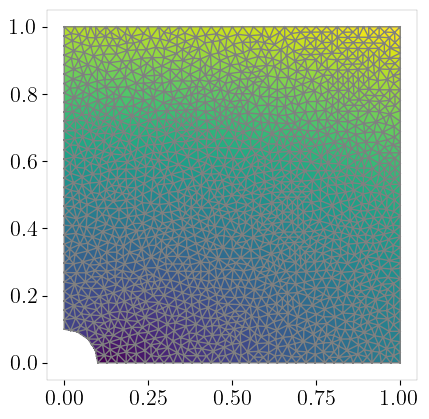

-5.519 + (var7(det(I + (grad(f_22))))) + (var5((1 + ({ A | A_{i_{48}, i_{49}} = sum_{i_{50}} (I + (grad(f_22)))[i_{50}, i_{49}] * ((I + (grad(f_22)))^T)[i_{48}, i_{50}]  })[0, 0] + ({ A | A_{i_{48}, i_{49}} = sum_{i_{50}} (I + (grad(f_22)))[i_{50}, i_{49}] * ((I + (grad(f_22)))^T)[i_{48}, i_{50}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var6((({ A | A_{i_{48}, i_{49}} = sum_{i_{50}} (I + (grad(f_22)))[i_{50}, i_{49}] * ((I + (grad(f_22)))^T)[i_{48}, i_{50}]  })[0, 0] + ({ A | A_{i_{48}, i_{49}} = sum_{i_{50}} (I + (grad(f_22)))[i_{50}, i_{49}] * ((I + (grad(f_22)))^T)[i_{48}, i_{50}]  })[1, 1] + -1 * ({ A | A_{i_{48}, i_{49}} = sum_{i_{50}} (I + (grad(f_22)))[i_{50}, i_{49}] * ((I + (grad(f_22)))^T)[i_{48}, i_{50}]  })[0, 1] * ({ A | A_{i_{48}, i_{49}} = sum_{i_{50}} (I + (grad(f_22)))[i_{50}, i_{49}] * ((I + (grad(f_22)))^T)[i_{48}, i_{50}]  })[1, 0] + ({ A | A_{i_{48}, i_{49}} = sum_{i_{50}} (I + (grad(f_22)))[i_{50}, i_{49}] * ((I + (grad(f_22)))^T)[

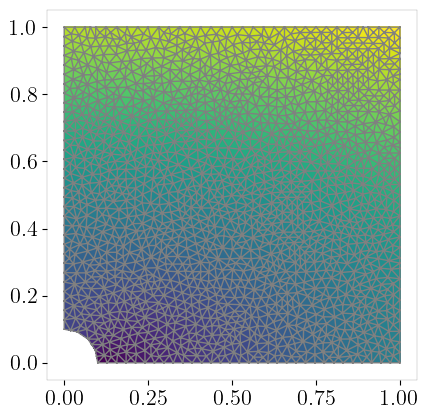

-5.519 + (var11(det(I + (grad(f_22))))) + (var9((1 + ({ A | A_{i_{53}, i_{54}} = sum_{i_{55}} (I + (grad(f_22)))[i_{55}, i_{54}] * ((I + (grad(f_22)))^T)[i_{53}, i_{55}]  })[0, 0] + ({ A | A_{i_{53}, i_{54}} = sum_{i_{55}} (I + (grad(f_22)))[i_{55}, i_{54}] * ((I + (grad(f_22)))^T)[i_{53}, i_{55}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var10((({ A | A_{i_{53}, i_{54}} = sum_{i_{55}} (I + (grad(f_22)))[i_{55}, i_{54}] * ((I + (grad(f_22)))^T)[i_{53}, i_{55}]  })[0, 0] + ({ A | A_{i_{53}, i_{54}} = sum_{i_{55}} (I + (grad(f_22)))[i_{55}, i_{54}] * ((I + (grad(f_22)))^T)[i_{53}, i_{55}]  })[1, 1] + -1 * ({ A | A_{i_{53}, i_{54}} = sum_{i_{55}} (I + (grad(f_22)))[i_{55}, i_{54}] * ((I + (grad(f_22)))^T)[i_{53}, i_{55}]  })[0, 1] * ({ A | A_{i_{53}, i_{54}} = sum_{i_{55}} (I + (grad(f_22)))[i_{55}, i_{54}] * ((I + (grad(f_22)))^T)[i_{53}, i_{55}]  })[1, 0] + ({ A | A_{i_{53}, i_{54}} = sum_{i_{55}} (I + (grad(f_22)))[i_{55}, i_{54}] * ((I + (grad(f_22)))^T

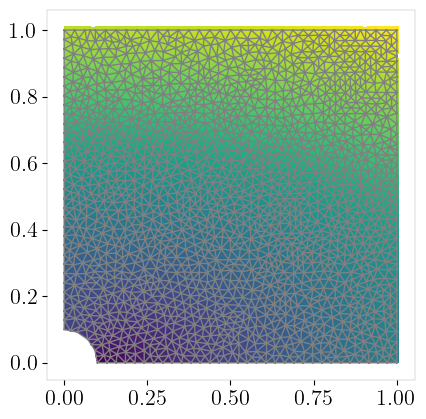

-5.519 + (var15(det(I + (grad(f_22))))) + (var13((1 + ({ A | A_{i_{58}, i_{59}} = sum_{i_{60}} (I + (grad(f_22)))[i_{60}, i_{59}] * ((I + (grad(f_22)))^T)[i_{58}, i_{60}]  })[0, 0] + ({ A | A_{i_{58}, i_{59}} = sum_{i_{60}} (I + (grad(f_22)))[i_{60}, i_{59}] * ((I + (grad(f_22)))^T)[i_{58}, i_{60}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var14((({ A | A_{i_{58}, i_{59}} = sum_{i_{60}} (I + (grad(f_22)))[i_{60}, i_{59}] * ((I + (grad(f_22)))^T)[i_{58}, i_{60}]  })[0, 0] + ({ A | A_{i_{58}, i_{59}} = sum_{i_{60}} (I + (grad(f_22)))[i_{60}, i_{59}] * ((I + (grad(f_22)))^T)[i_{58}, i_{60}]  })[1, 1] + -1 * ({ A | A_{i_{58}, i_{59}} = sum_{i_{60}} (I + (grad(f_22)))[i_{60}, i_{59}] * ((I + (grad(f_22)))^T)[i_{58}, i_{60}]  })[0, 1] * ({ A | A_{i_{58}, i_{59}} = sum_{i_{60}} (I + (grad(f_22)))[i_{60}, i_{59}] * ((I + (grad(f_22)))^T)[i_{58}, i_{60}]  })[1, 0] + ({ A | A_{i_{58}, i_{59}} = sum_{i_{60}} (I + (grad(f_22)))[i_{60}, i_{59}] * ((I + (grad(f_22)))^

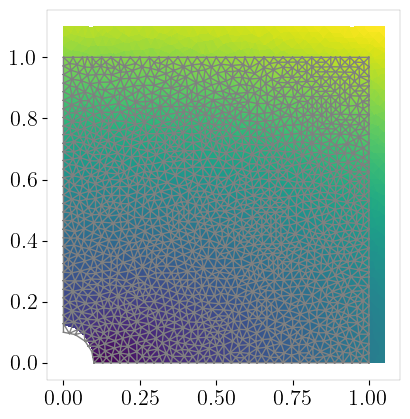

-5.519 + (var19(det(I + (grad(f_22))))) + (var17((1 + ({ A | A_{i_{63}, i_{64}} = sum_{i_{65}} (I + (grad(f_22)))[i_{65}, i_{64}] * ((I + (grad(f_22)))^T)[i_{63}, i_{65}]  })[0, 0] + ({ A | A_{i_{63}, i_{64}} = sum_{i_{65}} (I + (grad(f_22)))[i_{65}, i_{64}] * ((I + (grad(f_22)))^T)[i_{63}, i_{65}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var18((({ A | A_{i_{63}, i_{64}} = sum_{i_{65}} (I + (grad(f_22)))[i_{65}, i_{64}] * ((I + (grad(f_22)))^T)[i_{63}, i_{65}]  })[0, 0] + ({ A | A_{i_{63}, i_{64}} = sum_{i_{65}} (I + (grad(f_22)))[i_{65}, i_{64}] * ((I + (grad(f_22)))^T)[i_{63}, i_{65}]  })[1, 1] + -1 * ({ A | A_{i_{63}, i_{64}} = sum_{i_{65}} (I + (grad(f_22)))[i_{65}, i_{64}] * ((I + (grad(f_22)))^T)[i_{63}, i_{65}]  })[0, 1] * ({ A | A_{i_{63}, i_{64}} = sum_{i_{65}} (I + (grad(f_22)))[i_{65}, i_{64}] * ((I + (grad(f_22)))^T)[i_{63}, i_{65}]  })[1, 0] + ({ A | A_{i_{63}, i_{64}} = sum_{i_{65}} (I + (grad(f_22)))[i_{65}, i_{64}] * ((I + (grad(f_22)))^

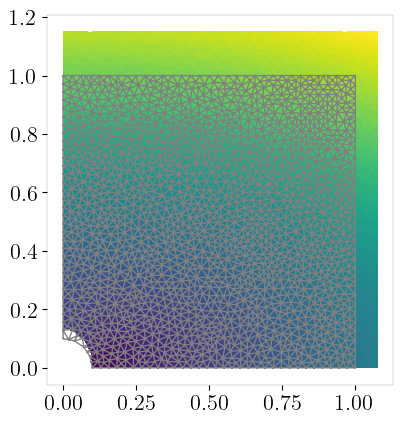

-5.519 + (var23(det(I + (grad(f_22))))) + (var21((1 + ({ A | A_{i_{68}, i_{69}} = sum_{i_{70}} (I + (grad(f_22)))[i_{70}, i_{69}] * ((I + (grad(f_22)))^T)[i_{68}, i_{70}]  })[0, 0] + ({ A | A_{i_{68}, i_{69}} = sum_{i_{70}} (I + (grad(f_22)))[i_{70}, i_{69}] * ((I + (grad(f_22)))^T)[i_{68}, i_{70}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var22((({ A | A_{i_{68}, i_{69}} = sum_{i_{70}} (I + (grad(f_22)))[i_{70}, i_{69}] * ((I + (grad(f_22)))^T)[i_{68}, i_{70}]  })[0, 0] + ({ A | A_{i_{68}, i_{69}} = sum_{i_{70}} (I + (grad(f_22)))[i_{70}, i_{69}] * ((I + (grad(f_22)))^T)[i_{68}, i_{70}]  })[1, 1] + -1 * ({ A | A_{i_{68}, i_{69}} = sum_{i_{70}} (I + (grad(f_22)))[i_{70}, i_{69}] * ((I + (grad(f_22)))^T)[i_{68}, i_{70}]  })[0, 1] * ({ A | A_{i_{68}, i_{69}} = sum_{i_{70}} (I + (grad(f_22)))[i_{70}, i_{69}] * ((I + (grad(f_22)))^T)[i_{68}, i_{70}]  })[1, 0] + ({ A | A_{i_{68}, i_{69}} = sum_{i_{70}} (I + (grad(f_22)))[i_{70}, i_{69}] * ((I + (grad(f_22)))^

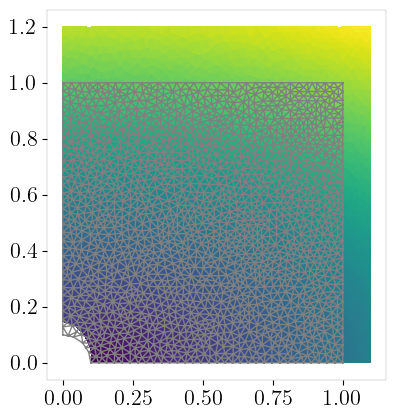

-5.519 + (var27(det(I + (grad(f_22))))) + (var25((1 + ({ A | A_{i_{73}, i_{74}} = sum_{i_{75}} (I + (grad(f_22)))[i_{75}, i_{74}] * ((I + (grad(f_22)))^T)[i_{73}, i_{75}]  })[0, 0] + ({ A | A_{i_{73}, i_{74}} = sum_{i_{75}} (I + (grad(f_22)))[i_{75}, i_{74}] * ((I + (grad(f_22)))^T)[i_{73}, i_{75}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var26((({ A | A_{i_{73}, i_{74}} = sum_{i_{75}} (I + (grad(f_22)))[i_{75}, i_{74}] * ((I + (grad(f_22)))^T)[i_{73}, i_{75}]  })[0, 0] + ({ A | A_{i_{73}, i_{74}} = sum_{i_{75}} (I + (grad(f_22)))[i_{75}, i_{74}] * ((I + (grad(f_22)))^T)[i_{73}, i_{75}]  })[1, 1] + -1 * ({ A | A_{i_{73}, i_{74}} = sum_{i_{75}} (I + (grad(f_22)))[i_{75}, i_{74}] * ((I + (grad(f_22)))^T)[i_{73}, i_{75}]  })[0, 1] * ({ A | A_{i_{73}, i_{74}} = sum_{i_{75}} (I + (grad(f_22)))[i_{75}, i_{74}] * ((I + (grad(f_22)))^T)[i_{73}, i_{75}]  })[1, 0] + ({ A | A_{i_{73}, i_{74}} = sum_{i_{75}} (I + (grad(f_22)))[i_{75}, i_{74}] * ((I + (grad(f_22)))^

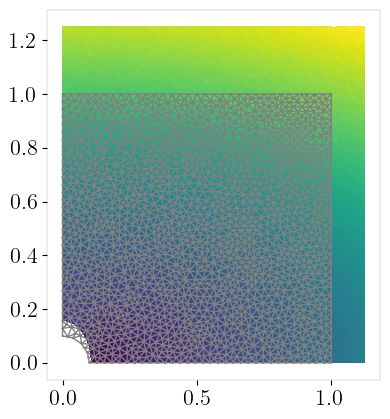

-5.519 + (var31(det(I + (grad(f_22))))) + (var29((1 + ({ A | A_{i_{78}, i_{79}} = sum_{i_{80}} (I + (grad(f_22)))[i_{80}, i_{79}] * ((I + (grad(f_22)))^T)[i_{78}, i_{80}]  })[0, 0] + ({ A | A_{i_{78}, i_{79}} = sum_{i_{80}} (I + (grad(f_22)))[i_{80}, i_{79}] * ((I + (grad(f_22)))^T)[i_{78}, i_{80}]  })[1, 1]) * (det(I + (grad(f_22)))) ** -0.6666666666666666)) + 0.2924 * (var30((({ A | A_{i_{78}, i_{79}} = sum_{i_{80}} (I + (grad(f_22)))[i_{80}, i_{79}] * ((I + (grad(f_22)))^T)[i_{78}, i_{80}]  })[0, 0] + ({ A | A_{i_{78}, i_{79}} = sum_{i_{80}} (I + (grad(f_22)))[i_{80}, i_{79}] * ((I + (grad(f_22)))^T)[i_{78}, i_{80}]  })[1, 1] + -1 * ({ A | A_{i_{78}, i_{79}} = sum_{i_{80}} (I + (grad(f_22)))[i_{80}, i_{79}] * ((I + (grad(f_22)))^T)[i_{78}, i_{80}]  })[0, 1] * ({ A | A_{i_{78}, i_{79}} = sum_{i_{80}} (I + (grad(f_22)))[i_{80}, i_{79}] * ((I + (grad(f_22)))^T)[i_{78}, i_{80}]  })[1, 0] + ({ A | A_{i_{78}, i_{79}} = sum_{i_{80}} (I + (grad(f_22)))[i_{80}, i_{79}] * ((I + (grad(f_22)))^

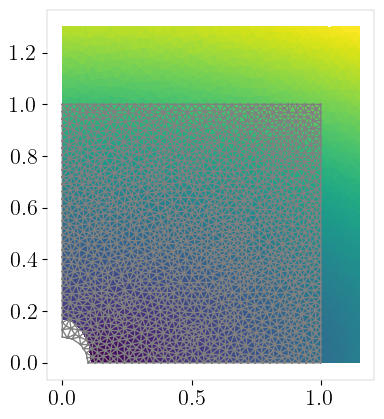

In [ ]:
disp_val = [0.000001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3]

for dd in range(0,len(disp_val)):
	applied_disp = disp_val[dd]
	u, du, v, f_int, f_ext, psi = problem_solve(applied_disp,u,du,v)
	fe.plot(u, mode="displacement")
	fe.plot(mesh)
	plt.show()